In [1]:
#training the model for one patient
from  statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train = pd.read_csv('/Users/shreyaananth/Desktop/College/CIP/Code/Awesome/Train1.csv')
test = pd.read_csv('/Users/shreyaananth/Desktop/College/CIP/Code/Awesome/Test1.csv')

In [2]:
#cleaning the data
#dropping Hour and Date column
train.drop(columns='Hour', inplace=True)
test.drop(columns='Hour', inplace=True)
train.drop(columns='Date', inplace=True)
test.drop(columns='Date', inplace=True)

#substituting the null values of glucose level with the mean of the other values, if present
n = train[train['BG'].isnull()].index.tolist()
if len(n)!=0:
    train['BG'][n] = np.mean(train['gl'])

n = test[test['BG'].isnull()].index.tolist()
if len(n)!=0:
    test['BG'][n] = np.mean(test['BG'])

In [3]:
#changing the data type of the date_time column from object to datetime
train['Time'] = pd.to_datetime(train['Time'])
test['Time'] = pd.to_datetime(test['Time'])

#removing seconds to ensure periodicity
train['Time'] = pd.to_datetime(train['Time']).dt.floor('T')
test['Time'] = pd.to_datetime(test['Time']).dt.floor('T')

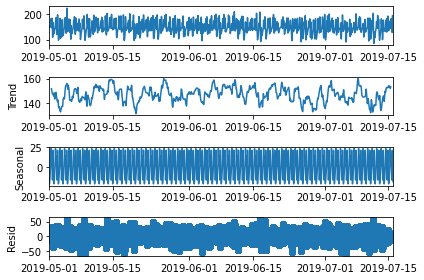

In [4]:
#creating new df for graphing purposes
train_plot = train.copy()
tdi = pd.DatetimeIndex(train_plot.Time)
tdi = pd.date_range(tdi[0],tdi[-1],freq='180S')
train_plot.set_index(tdi,inplace=True)
train_plot.drop(columns='Time',inplace=True)

decompose_data = seasonal_decompose(train_plot, period = 20*24, model="additive")
decompose_data.plot();

In [5]:
#checking for trend
result = adfuller(train.BG)
print(result)

(-20.255102149935205, 0.0, 13, 36466, {'1%': -3.4305293385723394, '5%': -2.8616192633175634, '10%': -2.566812189355308}, -405439.59667758516)


In [6]:
model = SARIMAX(train['BG'],order=(5, 1, 1),seasonal_order=(1,1,1,7))
model_fit = model.fit()

/Users/shreyaananth/miniforge3/envs/tf2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/shreyaananth/miniforge3/envs/tf2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/shreyaananth/miniforge3/envs/tf2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58535D+04    |proj g|=  3.85107D+07

At iterate    5    f= -1.14293D+00    |proj g|=  5.17930D+00

At iterate   10    f= -2.00110D+00    |proj g|=  1.97415D+00

At iterate   15    f= -2.07791D+00    |proj g|=  1.52817D+00

At iterate   20    f= -2.56227D+00    |proj g|=  8.33356D+00

At iterate   25    f= -2.99719D+00    |proj g|=  2.13646D+01

At iterate   30    f= -4.52075D+00    |proj g|=  6.39187D+01

At iterate   35    f= -4.67553D+00    |proj g|=  4.87267D+01

At iterate   40    f= -4.82085D+00    |proj g|=  3.28000D+01

At iterate   45    f= -4.82345D+00    |proj g|=  3.69980D+01

At iterate   50    f= -4.83334D+00    |proj g|=  8.77308D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/shreyaananth/miniforge3/envs/tf2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
fc = model_fit.forecast(20, alpha=0.1)
fc = fc.reset_index()
fc.drop(columns='index',inplace=True)
testing = test.iloc[0:20,:]

mse = mean_squared_error(fc, testing['BG'])
print("Actual\tPredicted")
for i in range(20):
    print(test['BG'][i], fc['predicted_mean'][i])

print("\nValue after 15 min (actual, predicted): ", test['BG'][4], fc['predicted_mean'][4])
print("Value after 60 min (actual, predicted): ", test['BG'][19], fc['predicted_mean'][19])
print("Mean squared error: ", mse)

Actual	Predicted
150.42795 150.42767601053617
149.6819539 149.68058277633145
148.9578117 148.9536605151489
148.2554856 148.24581910320043
147.5749034 147.55573140109374
146.9159605 146.8818263517398
146.2785229 146.22236335112498
145.6624293 145.57577341138003
145.0674932 144.94078292958292
144.4935053 144.31643328738588
143.9402353 143.70205972316182
143.4074337 143.09725041408223
142.8948338 142.5018021445317
142.4021531 141.91567877659156
141.9290951 141.3387107262267
141.4753507 140.77056231780156
141.0405997 140.21066972839338
140.6245118 139.6583329507048
140.2267481 139.11268624369373
139.8469623 138.5726722689394

Value after 15 min (actual, predicted):  147.5749034 147.55573140109374
Value after 60 min (actual, predicted):  139.8469623 138.5726722689394
Mean squared error:  0.29681527451101974


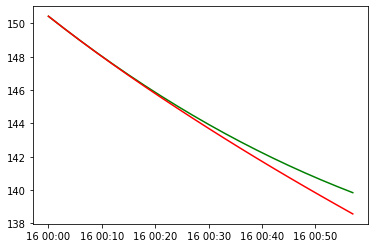

In [8]:
fig, plt1= plt.subplots()
plt1.plot(test.iloc[0:20,0], test.iloc[0:20,1], color="green")
plt1.plot(test.iloc[0:20,0], fc['predicted_mean'], color="red")

In [9]:
#LSTM model to predict the glucose level
#look_back = 1

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

p = train.iloc[:-1, 1]
q = train.iloc[1:,1]

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(p, q, epochs = 100, batch_size = 32)

2022-06-02 11:27:03.680988: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
1140/1140 [==============================] - 4s 2ms/step - loss: 14203.4961
Epoch 2/100
1140/1140 [==============================] - 2s 2ms/step - loss: 6531.9067
Epoch 3/100
1140/1140 [==============================] - 2s 2ms/step - loss: 2673.1594
Epoch 4/100
1140/1140 [==============================] - 2s 2ms/step - loss: 1072.8777
Epoch 5/100
1140/1140 [==============================] - 2s 2ms/step - loss: 653.5510
Epoch 6/100
1140/1140 [==============================] - 2s 2ms/step - loss: 608.4173
Epoch 7/100
1140/1140 [==============================] - 2s 2ms/step - loss: 602.9817
Epoch 8/100
1140/1140 [==============================] - 2s 2ms/step - loss: 608.3797
Epoch 9/100
1140/1140 [==============================] - 2s 2ms/step - loss: 602.9260
Epoch 10/100
1140/1140 [==============================] - 2s 2ms/step - loss: 603.9719
Epoch 11/100
1140/1140 [==============================] - 2s 2ms/step - loss: 603.7157
Epoch 12/100
1140/1140 [=======================

1140/1140 [==============================] - 2s 2ms/step - loss: 80.5704
Epoch 96/100
1140/1140 [==============================] - 2s 2ms/step - loss: 79.6069
Epoch 97/100
1140/1140 [==============================] - 2s 2ms/step - loss: 79.2347
Epoch 98/100
1140/1140 [==============================] - 2s 2ms/step - loss: 78.3620
Epoch 99/100
1140/1140 [==============================] - 2s 2ms/step - loss: 78.6530
Epoch 100/100
1140/1140 [==============================] - 2s 2ms/step - loss: 77.9742


In [10]:
p = test.iloc[:-1, 1]
q = test.iloc[1:,1]
predictions = model.predict(p)

In [11]:
pred = []
for i in range(len(predictions)):
    pred.append(predictions[i][0])
print("Actual Predicted")
for i in range(len(pred)):
    print(q[i+1], pred[i])

Actual Predicted
149.6819539 146.1705
148.9578117 145.54251
148.2554856 144.93913
147.5749034 144.35945
146.9159605 143.80278
146.2785229 143.26808
145.6624293 142.75427
145.0674932 142.26036
144.4935053 141.78523
143.9402353 141.32788
143.4074337 140.88733
142.8948338 140.46275
142.4021531 140.05331
141.9290951 139.65836
141.4753507 139.27737
141.0405997 138.90988
140.6245118 138.5556
140.2267481 138.21425
139.8469623 137.88567
139.4848016 137.56976
139.1399078 137.26648
138.8119182 136.97568
138.5004666 136.69739
138.205184 136.4315
137.9256996 136.17801
137.6616411 135.93683
137.4126358 135.70789
137.1783111 135.49101
136.9582948 135.28613
136.752216 135.09315
136.5597055 134.91174
136.3803962 134.74191
136.2139234 134.58328
136.0599255 134.43568
135.9180441 134.29887
135.7879243 134.17271
135.6692154 134.05673
135.5615705 133.95085
135.4646474 133.85472
135.3781083 133.76807
135.3016203 133.69067
135.2348548 133.62222
135.1774871 133.56241
135.1291924 133.51103
135.0896348 133.4677

In [14]:
import math
mse = mean_squared_error(pred, q)
print("Value after 15 min (actual, predicted): ", q[3], pred[2])
print("Value after 60 min (actual, predicted): ", q[12], pred[11])

print('\nRoot mean squared error: ',math.sqrt(mse))
print('Mean squared error: ',mse)

Value after 15 min (actual, predicted):  148.2554856 144.93913
Value after 60 min (actual, predicted):  142.8948338 140.46275

Root mean squared error:  3.967288954469125
Mean squared error:  15.739381648252722


Text(0, 0.5, 'predict')

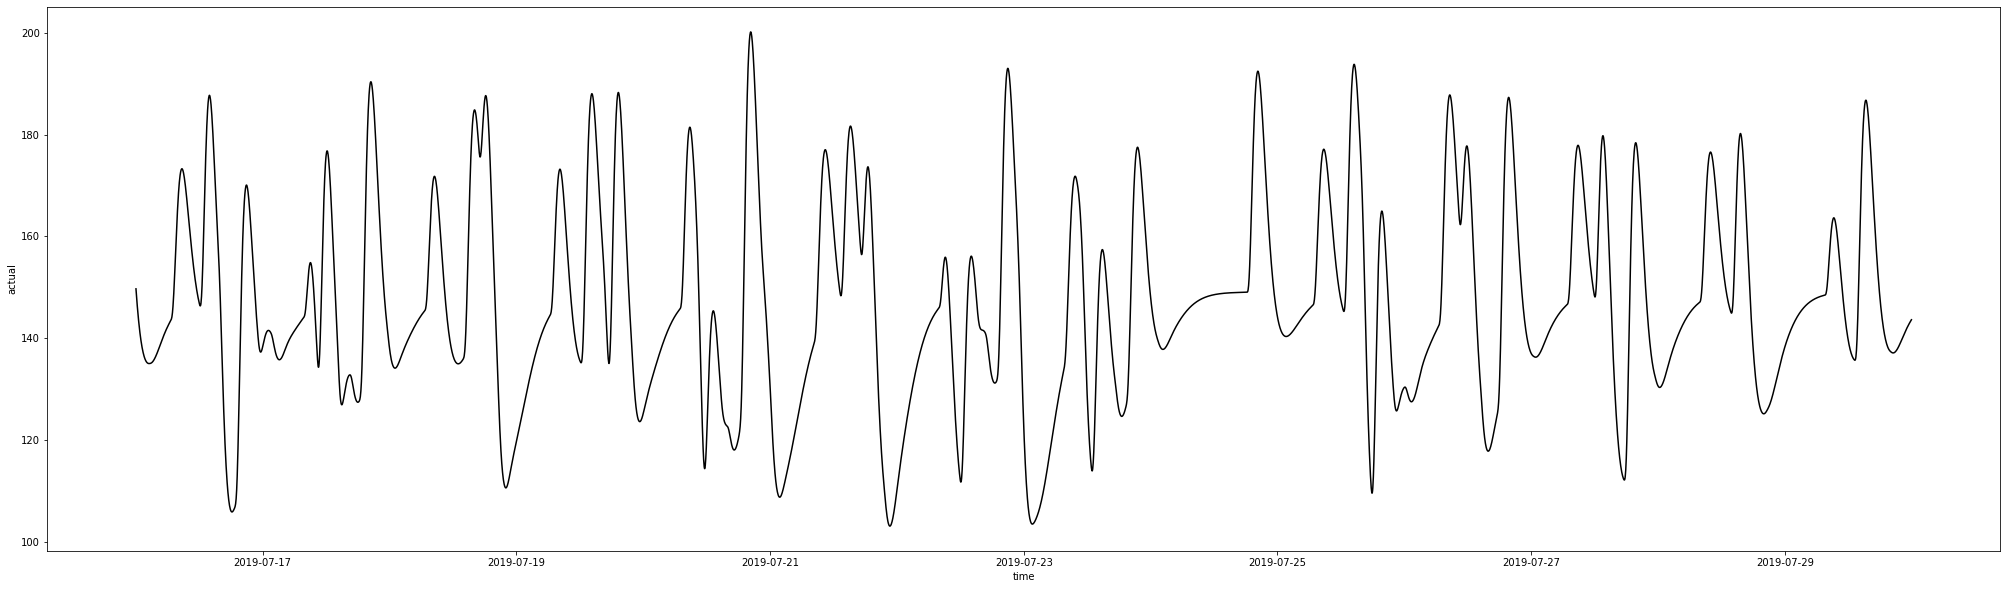

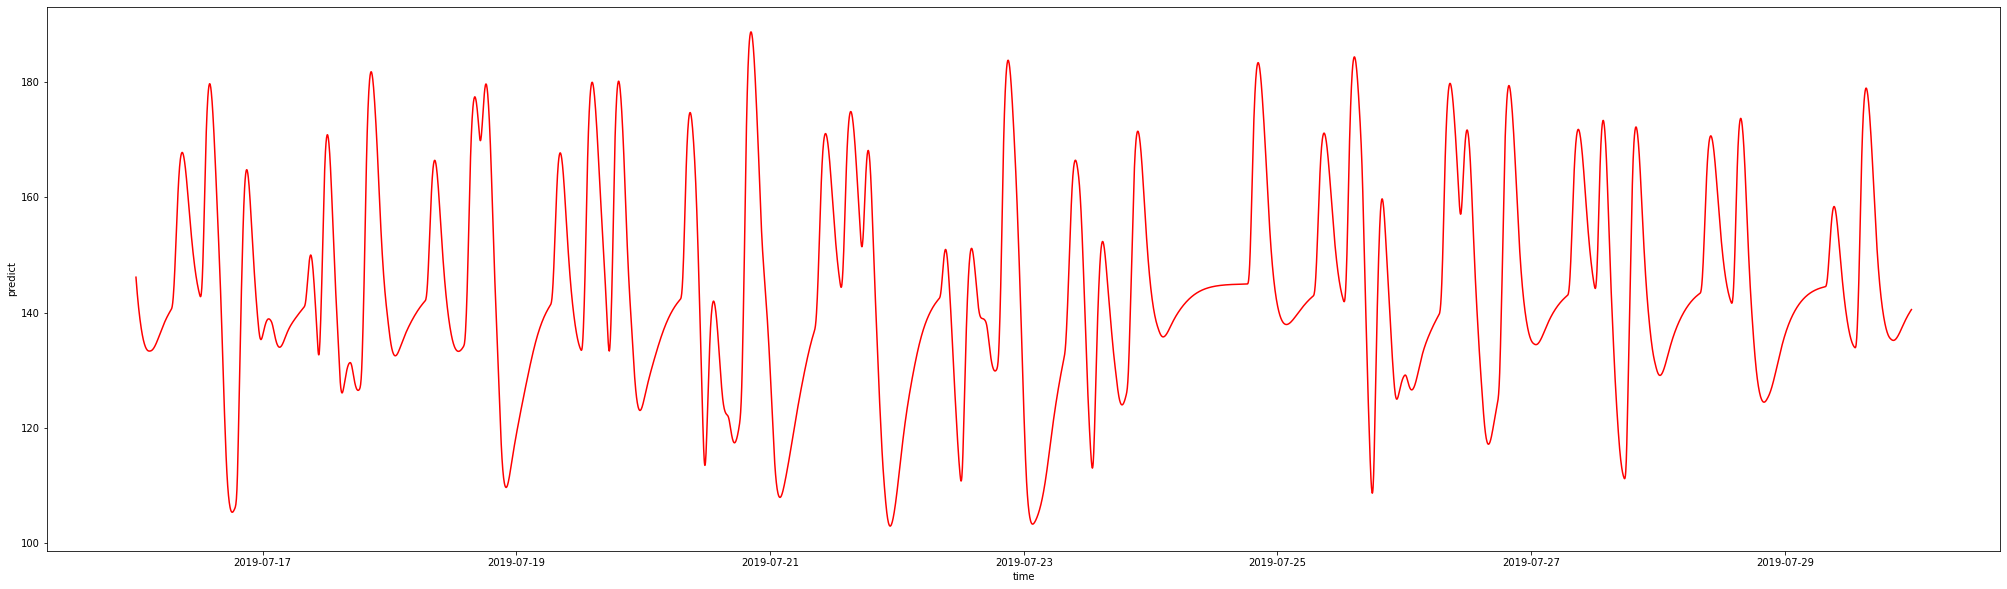

In [15]:
time = test.iloc[1:,0]
fig1, act = plt.subplots()
fig2, predict = plt.subplots()
fig1.set_figwidth(35)
fig1.set_figheight(10)
fig2.set_figwidth(35)
fig2.set_figheight(10)

act.plot(time, q, color="black")
act.set_xlabel("time")
act.set_ylabel("actual")
predict.plot(time, pred, color="red")
predict.set_xlabel("time")
predict.set_ylabel("predict")